Resources:

https://www.tensorflow.org/hub/tutorials/movenet

https://www.kaggle.com/models/google/movenet/frameworks/tensorFlow2/variations/multipose-lightning

https://www.youtube.com/watch?v=KC7nJtBHBqg&ab_channel=NicholasRenotte

In [1]:
# Import TF and TF Hub libraries.
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check for GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [3]:
# Download the model from TF Hub.
model = hub.load("https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/multipose-lightning/versions/1")
movenet = model.signatures['serving_default']

In [4]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}
(255,0,0)
(0,255,0)
(0,0,255)
# Maps bones to an RGB color
EDGES_DICT = {
    (0, 1): (255,0,0),
    (0, 2): (0,0,255),
    (1, 3): (255,0,0),
    (2, 4): (0,0,255),
    (0, 5): (255,0,0),
    (0, 6): (0,0,255),
    (5, 7): (255,0,0),
    (7, 9): (255,0,0),
    (6, 8): (0,0,255),
    (8, 10): (0,0,255),
    (5, 6): (0,255,0),
    (5, 11): (255,0,0),
    (6, 12): (0,0,255),
    (11, 12): (0,255,0),
    (11, 13): (255,0,0),
    (13, 15): (255,0,0),
    (12, 14): (0,0,255),
    (14, 16): (0,0,255)
}

In [5]:
def draw_keypoints(frame, keypoints_with_scores, confidence_threshold):
    img = frame.copy()
    height, width, _ = img.shape

    for person in keypoints_with_scores:
        for kp in person:
            if kp[2] > confidence_threshold:
                cv2.circle(img, (int(kp[1]*width),int(kp[0]*height)), radius=10, color=(255,255,255), thickness=-1)
    return img

#frame_with_keypoints = draw_keypoints(frame, keypoints_with_scores, 0.3)

In [6]:
def draw_edges(frame, keypoints_with_scores, confidence_threshold):
    img = frame.copy()
    height, width, _ = img.shape

    for person in keypoints_with_scores:
        for edge in EDGES_DICT.keys():
            kp_1 = person[edge[0]]
            kp_2 = person[edge[1]]
            if (kp_1[2] > confidence_threshold) and (kp_2[2] > confidence_threshold):
                cv2.line(img,(int(kp_1[1]*width),int(kp_1[0]*height)),(int(kp_2[1]*width),int(kp_2[0]*height)),color=EDGES_DICT[edge], thickness=5)
    return img

#frame_with_edges = draw_edges(frame_with_keypoints, keypoints_with_scores, 0.3)

In [7]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture a frame. Exiting...")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Prepare frame for detection
    image = frame.copy()
    image = tf.expand_dims(image, axis=0)
    # Resize with zero padding (if aspect ratio doesn't match the original one)
    image = tf.image.resize_with_pad(image,160,256)
    image = tf.cast(image, dtype=tf.int32)
    
    # Detect
    results = movenet(image)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

    # Set confidence threshold
    confidence_threshold = 0.4

    frame_with_keypoints= draw_keypoints(frame, keypoints_with_scores, confidence_threshold)
    frame_with_keypoints_and_edges = draw_edges(frame_with_keypoints, keypoints_with_scores, confidence_threshold)
    # Display the frame
    cv2.imshow('MoveNet', frame_with_keypoints_and_edges)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

2024-01-06 19:58:33.559 python[78136:3144815] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


-1

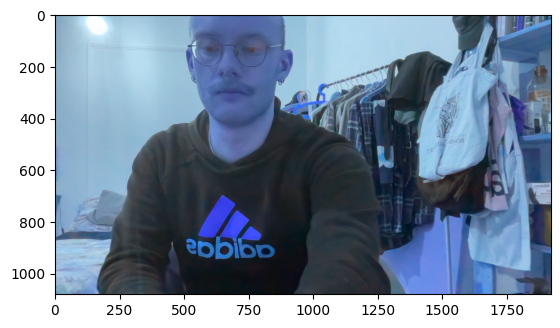

In [8]:
plt.imshow(frame)

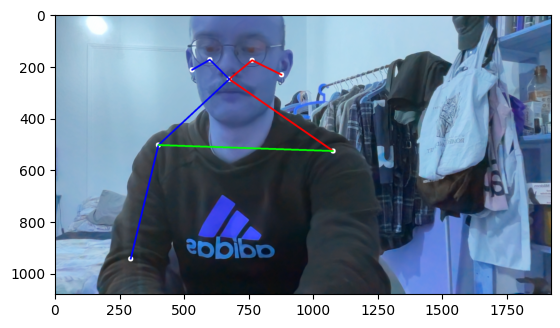

In [9]:
plt.imshow(frame_with_keypoints_and_edges)